# Mapping Space With Location Beliefs

In [Developing Spatial Memory], we built a spatial map to serve as a memory for an agent. However, this map assumed that the locations were represented as vectors in $\mathbb{R}^d$. Animals instead represent space using _grid cells_ that fire when the animal is at a particular location. This is better modeled by a grid of locations rather than a single vector. Furthermore, once space is represented by the activations of a grid of neurons, it is better to think of the representation as a _location belief_, that is, as a probability over the organism's location, analogous to the Gaussian model used with vector locations.

With spatial grid of size $S \times S$ for integer $S > 0$, we define a location belief $\ell \in \mathbb{R}^{S\times S} \approxeq \mathbb{R}^{S^2}$, and suppose $S = 2R + 1$ for another integer $R$, so that the bounds of the space are $[-R, R]$ in each dimension. We assume a spatial scale $\gamma > 0$ and interpret $\ell_{ij}$ to represent the point $\left(\vphantom{x^{x^x}}\gamma (i - R), \gamma (j-R)\right)$ in $\mathbb{R}^2$. 

This location belief acts like the pixels of an image and can be displayed as an image. Below, we define conversions between points and pixels and display a simple Gaussian location belief.

grid.shape: torch.Size([101, 101, 2])
point_values[0,0]: [-10.0, -10.0]


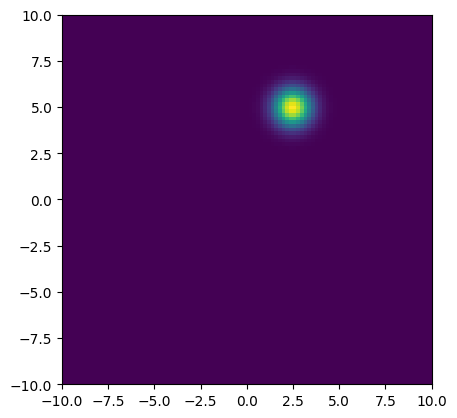

In [1]:
import torch
from matplotlib import pyplot as plt

def map_index_to_space(indices, R, gamma):
    return gamma * (indices - R)

def map_space_to_preindex(x, R, gamma):
    return x / gamma + R


R = 50
real_magnitude = 10.0  # distance from origin to edge along axis
grid_size = 2 * R + 1   # R = 50
gamma = 2 * real_magnitude / (grid_size - 1)  # gamma
grid_points = torch.arange(grid_size)
grid = torch.cartesian_prod(grid_points, grid_points).view(grid_size, grid_size, 2)  # (101, 101, 2)
point_values = map_index_to_space(grid, R, gamma)
print(f"grid.shape: {grid.shape}")
print(f"point_values[0,0]: {point_values[0,0].detach().cpu().numpy().tolist()}")

x = 2.5
y = 5.0
centroid = torch.tensor([[y, x]])
# we use y, x because images are represented as (row, column) for (height, width) -- which is (y, x) in the grid
location_belief = torch.exp(-(point_values - centroid).pow(2).sum(dim=-1)).unsqueeze(0)
location_belief = location_belief / location_belief.sum()

plt.imshow(
    location_belief.squeeze(0),
    extent=[-10, 10, -10, 10],   # x_min, x_max, y_min, y_max
    origin='lower',
)

## Setting Up the World

Our Tree World agent lives in 2D and needs a world as described in [Simulation Experiments](./simulation-dev.ipynb). Let's create a world, define our sensory environment, and develop a PCA color map for sensors, as we did in [Developing Spatial Memory](./map_testing.ipynb).

In [2]:
from tree_world.simulation import TreeWorldConfig, TreeWorld, SimpleSensor

R = 50
D = 1024
S = 2 * R + 1
real_magnitude = 500.0
gamma = 2 * real_magnitude / (S - 1)

grid_points = torch.arange(grid_size)
grid = torch.cartesian_prod(grid_points, grid_points).view(grid_size, grid_size, 2)  # (101, 101, 2)
grid_locations = map_index_to_space(grid, R, gamma)

config = TreeWorldConfig()
config.embedding_dim = D
sensor = SimpleSensor.from_config(config)
world = TreeWorld.random_from_config(config)

In [3]:
_, sensor_values, _ = sensor.sense(world, grid_locations.view(-1, 2), None)

In [4]:
# generate a 3D embedding of the sensor values
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def make_rgb_model_from_sensor_values(values: torch.Tensor):

    sensor_np = values.cpu().numpy()

    N = sensor_np.shape[0]
    k = min(4000, N)                    # tune subset size
    idx = np.random.RandomState(42).choice(N, size=k, replace=False)    

    pca = PCA(n_components=3)
    rgb = pca.fit_transform(sensor_np[idx])
    return lambda x: pca.transform(x), rgb.min(axis=0), rgb.max(axis=0)

In [5]:
rgb_model, rgb_min, rgb_max = make_rgb_model_from_sensor_values(sensor_values)

In [6]:
import math

def plot_sensor_field(values: torch.Tensor, key="Sensor Field"):
    rgb = rgb_model(values.cpu().detach().numpy())

    # normalize the colors to be between 0 and 1 for display
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb = np.clip(rgb, 0, 1)

    H = W = int(math.sqrt(values.shape[0]))
    img = rgb.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (PCA colors)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig, ax

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


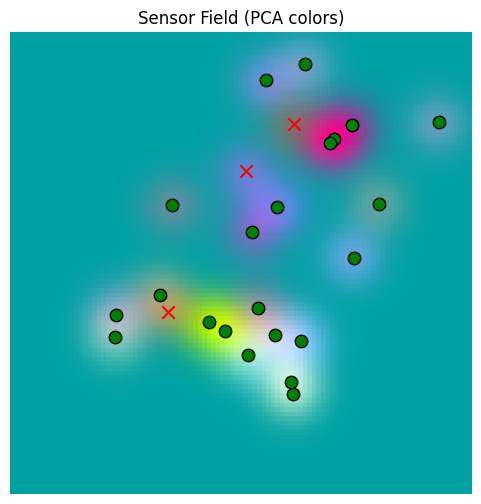

In [7]:
base_sensor_field, fig, ax = plot_sensor_field(sensor_values)

## Implementing Memory Read & Write

As in the spatial case, our memory is quite literally just a record of everything written to the memory. So writing is trivial. 

As a first approach to reading, we perform a simple attention operation over the memory. However, the location beliefs are probability distributions, so the pre-attention values (dot products) are between 0 and 1. Hence, we take a log before applying softmax so that zero-probability locations are given zero attention.

As discussed in [Developing Spatial Memory](./map_testing.ipynb), we have to consider the possibility that the "best matches" are bad, and so we allow a `match_threshold` parameter. Unlike in the spatial case, this is applied at the level of probabilities and should be between 0 and 1. The actual value should be $\approx 1 / S^2$, which is to say, "greater than uniform probability over the number of pixels".

Also, we want to rule out "no match" cases, which is done with the `zero_invalid` parameter, forcing a zero response for queries that have no supporting locations in the memory.

Finally, to anticipate pruning, we add the `mask_diagonal` parameter for use below.

In [8]:
from typing import Optional


def memory_write(
    memory_locations: Optional[torch.Tensor],
    memory_values: Optional[torch.Tensor],
    location_beliefs: torch.Tensor,
    sensory_data: torch.Tensor,
):
    # memory_locations: (B, T, S, S)
    # memory_values: (B, T, D)
    # location_beliefs: (B, S, S) or (B, N, S, S)  # N is the number of memory locations
    # sensory_data: (B, D)
    # return (B, T, D) or (B, N, D)
    assert sensory_data.ndim + 1 == location_beliefs.ndim, "sensory_data and location_beliefs must have a compatible number of dimensions"
    
    if location_beliefs.ndim == 3:
        location_beliefs = location_beliefs.unsqueeze(1)
        sensory_data = sensory_data.unsqueeze(1)

    if memory_locations is None:
        assert sensory_data.ndim == 3
        assert location_beliefs.ndim == 4
        memory_locations = location_beliefs.clone()
        memory_values = sensory_data.clone()
        return memory_locations, memory_values

    assert sensory_data.ndim == memory_values.ndim == 3  
    assert memory_locations.ndim == location_beliefs.ndim == 4
    
    return (
        torch.cat([memory_locations, location_beliefs], dim=1),
        torch.cat([memory_values, sensory_data], dim=1),
    )

def memory_read(
    memory_locations: torch.Tensor,
    memory_values: torch.Tensor,
    location_beliefs: torch.Tensor,
    mask_diagonal: bool = False,
    zero_invalid: bool = True,
    match_threshold: float = None,
    return_weights: bool = False,
) -> torch.Tensor:
    # memory_locations: (B, T, S, S)
    # memory_values: (B, T, D)
    # location_beliefs: (B, S, S) or (B, Q, S, S)  # Q is the number of query locations
    # return (B, D) or (B, Q, D)

    single_query = False
    if location_beliefs.ndim == 3:
        single_query = True
        location_beliefs = location_beliefs.unsqueeze(1)


    batch_size, time_steps, _, _ = memory_locations.shape
    num_queries = location_beliefs.shape[1]
    memory_locations = memory_locations.view(batch_size, time_steps, -1)
    location_beliefs = location_beliefs.view(batch_size, num_queries, -1)

    # compute the location affinity as (B, Q, T)
    # we use log here because the location affinity is a probability distribution, so the affinity is between 0 and 1
    location_affinity = torch.bmm(location_beliefs, memory_locations.transpose(1, 2))

    if match_threshold is not None:
        assert 0.0 < match_threshold < 1.0, "match_threshold must be greater than 0 and less than 1"
        location_affinity = location_affinity.masked_fill(location_affinity < match_threshold, 0.0)

    if mask_diagonal:
        assert time_steps == num_queries, "mask_diagonal is only supported when the number of query locations is equal to the number of memory locations"
        diagonal_mask = torch.eye(time_steps, device=location_affinity.device, dtype=torch.bool).unsqueeze(0)
        location_affinity = location_affinity.masked_fill(diagonal_mask, 0.0)

    # compute the attention weights as (B, Q, T)
    # we use log here because the location affinity is a probability distribution, so the affinity is between 0 and 1
    attention_weights = torch.softmax(torch.log(location_affinity), dim=-1)

    if zero_invalid:
        invalid = location_affinity.sum(dim=-1, keepdim=True) <= 0
        print(f"Total invalid: {invalid.long().sum()}")
        attention_weights = attention_weights.masked_fill(invalid, 0.0)

    # compute the new memory values as (B, Q, D)
    new_memory_values = torch.bmm(attention_weights, memory_values)

    if single_query:
        return new_memory_values.squeeze(1)

    if return_weights:
        return new_memory_values, attention_weights
    else:
        return new_memory_values

In [9]:
all_centroids = grid_locations.view(1, -1, 2)

# Note that our grid is 101x101, so the space between each pixel is about 5 units (real_magnitude / R)
# For visibility, we'll use 10 here, which puts the first standard deviation at about 2 pixels out
sd = 10

all_location_beliefs = torch.exp(-((grid_locations.view(1, -1, 1, 2) - all_centroids.unsqueeze(1)) / sd).pow(2).sum(dim=-1))
all_location_beliefs = all_location_beliefs / all_location_beliefs.sum(dim=-1, keepdim=True)

print(f"all_centroids.shape: {all_centroids.shape}")
print(f"all_location_beliefs.shape: {all_location_beliefs.shape}")

print(f"all_centroids[0,0]: {all_centroids[0,0].detach().cpu().numpy().tolist()}")
print(f"all_location_beliefs[0,0]: {all_location_beliefs[0,0,0].detach().cpu().numpy().tolist()}")



all_centroids.shape: torch.Size([1, 10201, 2])
all_location_beliefs.shape: torch.Size([1, 10201, 10201])
all_centroids[0,0]: [-500.0, -500.0]
all_location_beliefs[0,0]: 0.5203240513801575


check_indices: tensor([76, 45])
combined_index: 4621


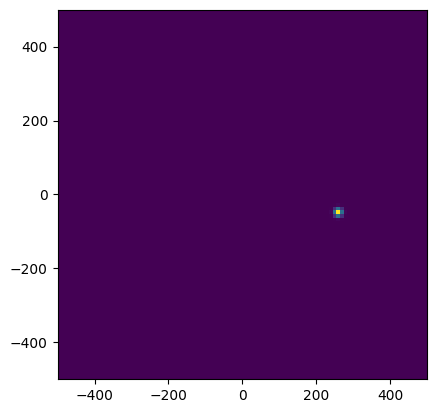

In [10]:
point_to_check = torch.tensor([256, -50])
check_indices = map_space_to_preindex(point_to_check, R, gamma).round().long()

print(f"check_indices: {check_indices}")

combined_index = check_indices[0] + check_indices[1] * S

print(f"combined_index: {combined_index}")

location_belief_at_point = all_location_beliefs[0,combined_index.item()].view(S, S)

plt.imshow(
    location_belief_at_point.detach().cpu().numpy(),
    extent=[-real_magnitude, real_magnitude, -real_magnitude, real_magnitude],
    origin='lower',
)




In [11]:
print(f"sensor_values.shape: {sensor_values.shape}")
print(f"all_location_beliefs.shape: {all_location_beliefs.shape}")

memory_locations, memory_values = memory_write(
    memory_locations=None,
    memory_values=None,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
    sensory_data=sensor_values.unsqueeze(0),
)

print(f"memory_locations.shape: {memory_locations.shape}")
print(f"memory_values.shape: {memory_values.shape}")

sensor_values.shape: torch.Size([10201, 1024])
all_location_beliefs.shape: torch.Size([1, 10201, 10201])
memory_locations.shape: torch.Size([1, 10201, 101, 101])
memory_values.shape: torch.Size([1, 10201, 1024])


Total invalid: 0
memory_read.shape: torch.Size([1, 10201, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


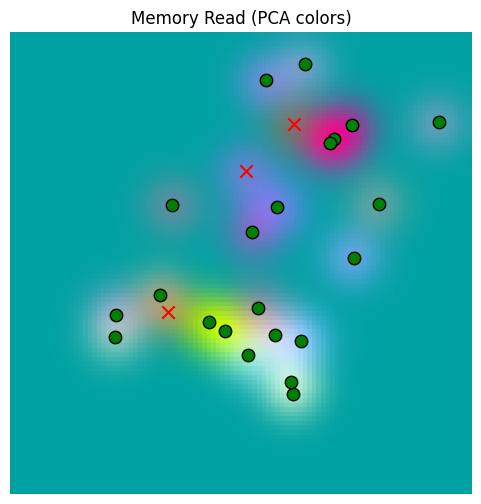

In [12]:
memory_read_result = memory_read(
    memory_locations=memory_locations,
    memory_values=memory_values,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
)

print(f"memory_read.shape: {memory_read_result.shape}")

_ = plot_sensor_field(memory_read_result.squeeze(0), "Memory Read")

Our basic memory read / write works. But now we need to test it when we write with less data. Let's use a grid of 10 points across the space, and widen out our location read sd as well.

In [13]:
coarse_num_points = 10
coarse_grid_points = torch.linspace(0, S, coarse_num_points)
coarse_grid = torch.cartesian_prod(coarse_grid_points, coarse_grid_points).view(coarse_num_points, coarse_num_points, 2)  # (101, 101, 2)
coarse_grid_locations = map_index_to_space(coarse_grid, R, gamma)

coarse_centroids = coarse_grid_locations.view(1, -1, 1, 2)

# we are reading 10 points over 1000, so there are 100 units between each point
# sd = 25 makes the second standard deviation of each location belief touch at the edges
coarse_sd = 25

coarse_location_beliefs = torch.exp(-((grid_locations.view(1, 1, -1, 2) - coarse_centroids) / coarse_sd).pow(2).sum(dim=-1))
coarse_location_beliefs = coarse_location_beliefs / coarse_location_beliefs.sum(dim=-1, keepdim=True)

print(f"coarse_centroids.shape: {coarse_centroids.shape}")
print(f"coarse_location_beliefs.shape: {coarse_location_beliefs.shape}")

print(f"coarse_centroids[0,0]: {coarse_centroids[0,0].detach().cpu().numpy().tolist()}")
print(f"coarse_location_beliefs[0,0]: {coarse_location_beliefs[0,0,0].detach().cpu().numpy().tolist()}")

coarse_centroids.shape: torch.Size([1, 100, 1, 2])
coarse_location_beliefs.shape: torch.Size([1, 100, 10201])
coarse_centroids[0,0]: [[-500.0, -500.0]]
coarse_location_beliefs[0,0]: 0.13560599088668823


coarse_memory_locations.shape: torch.Size([1, 100, 101, 101])
coarse_memory_values.shape: torch.Size([1, 100, 1024])
Total invalid: 0
coarse_memory_read_result.shape: torch.Size([1, 10201, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


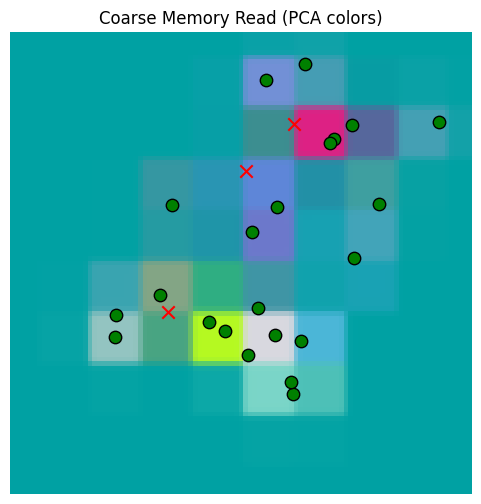

In [14]:
_, coarse_sensor_values, _ = sensor.sense(world, coarse_grid_locations.view(-1, 2), None)

coarse_memory_locations, coarse_memory_values = memory_write(
    memory_locations=None,
    memory_values=None,
    location_beliefs=coarse_location_beliefs.view(1, -1, S, S),
    sensory_data=coarse_sensor_values.unsqueeze(0),
)

print(f"coarse_memory_locations.shape: {coarse_memory_locations.shape}")
print(f"coarse_memory_values.shape: {coarse_memory_values.shape}")

coarse_memory_read_result = memory_read(
    memory_locations=coarse_memory_locations,
    memory_values=coarse_memory_values,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
)

print(f"coarse_memory_read_result.shape: {coarse_memory_read_result.shape}")

_ = plot_sensor_field(coarse_memory_read_result.squeeze(0), "Coarse Memory Read")



Our coarse memory is doing the best that can be hoped for. Now let's choose a random set of points around the origin to write to the memory.

In [15]:
random_centroids = torch.clamp(torch.randn(1, 100, 1, 2) * 100.0, -real_magnitude, real_magnitude)

# we are reading 10 points over 1000, so there are 100 units between each point
# sd = 25 makes the second standard deviation of each location belief touch at the edges
random_sd = 25

random_location_beliefs = torch.exp(-((grid_locations.view(1, 1, -1, 2) - random_centroids) / random_sd).pow(2).sum(dim=-1))
random_location_beliefs = random_location_beliefs / random_location_beliefs.sum(dim=-1, keepdim=True)

print(f"random_centroids.shape: {random_centroids.shape}")
print(f"random_location_beliefs.shape: {random_location_beliefs.shape}")

print(f"random_centroids[0,0]: {random_centroids[0,0].detach().cpu().numpy().tolist()}")
print(f"random_location_beliefs[0,0]: {random_location_beliefs[0,0,0].detach().cpu().numpy().tolist()}")

random_centroids.shape: torch.Size([1, 100, 1, 2])
random_location_beliefs.shape: torch.Size([1, 100, 10201])
random_centroids[0,0]: [[-81.64852905273438, -71.74051666259766]]
random_location_beliefs[0,0]: 0.0


random_memory_locations.shape: torch.Size([1, 100, 101, 101])
random_memory_values.shape: torch.Size([1, 100, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Total invalid: 2291
random_memory_read_result.shape: torch.Size([1, 10201, 1024])


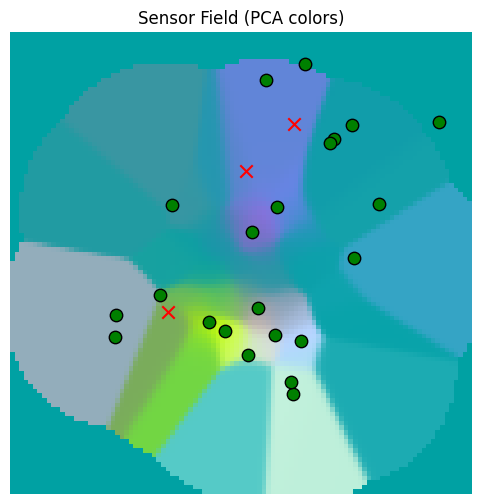

In [16]:
_, random_sensor_values, _ = sensor.sense(world, random_centroids.view(-1, 2), None)

random_memory_locations, random_memory_values = memory_write(
    memory_locations=None,
    memory_values=None,
    location_beliefs=random_location_beliefs.view(1, -1, S, S),
    sensory_data=random_sensor_values.unsqueeze(0),
)

print(f"random_memory_locations.shape: {random_memory_locations.shape}")
print(f"random_memory_values.shape: {random_memory_values.shape}")

random_memory_read_result = memory_read(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
)

print(f"random_memory_read_result.shape: {random_memory_read_result.shape}")

_ = plot_sensor_field(random_memory_read_result.squeeze(0))


Now we'll use the match_threshold parameter to get rid of those large regions that are unsupported by much evidence.

Total invalid: 7709


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


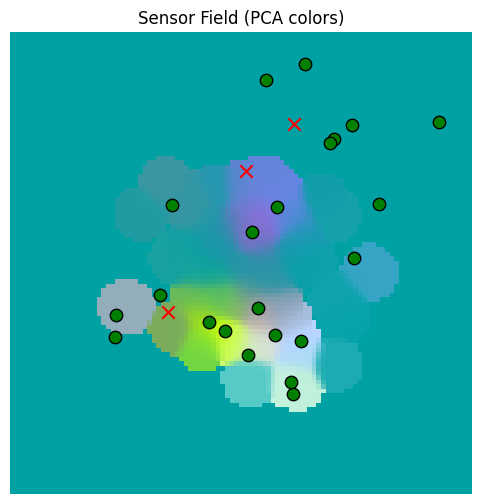

In [17]:
match_threshold = 2 / S**2

random_memory_read_result_thresholded = memory_read(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
    match_threshold=match_threshold,
)

_ = plot_sensor_field(random_memory_read_result_thresholded.squeeze(0))

Let's replot the sensors for comparison.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


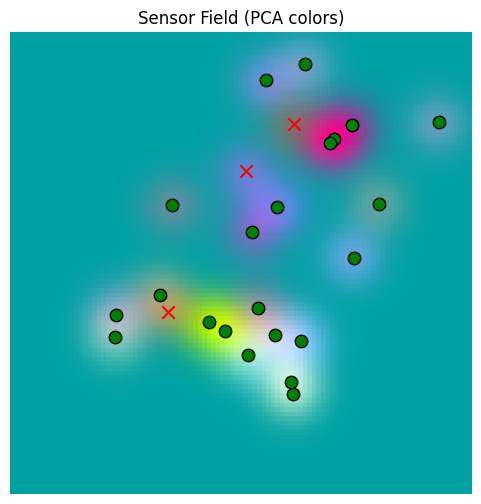

In [18]:
_ = plot_sensor_field(sensor_values.squeeze(0))

## Sampling the Memory with a Search Key

Since sampling depends on the inserted values, and not so much the locations, very little is changed here for sampling with location beliefs vs. a sampling map.

As we did in [Developing Spatial Memory](./map_testing.ipynb), we'll use a drive classification on the sensory data so that we can search for regions of space where, e.g., edible fruit can be found; see that notebook for a longer explanation.

In [19]:
from tree_world.models.drives import train_drive_classifier

# we only want to train on the tree names (e.g. mango, pear, etc.), not the ids (Bob, Alice, etc.)
drive_classifier, drive_keys = train_drive_classifier(config, with_ids=False)
inverse_drive_keys = {v: k for k, v in drive_keys.items()}

print("--------------------------------")

tree_classifications = drive_classifier(torch.stack([tree.embedding for tree in world.trees]))
for tree, classification in zip(world.trees, tree_classifications):
    drive_idx = classification.argmax().item()
    drive = inverse_drive_keys[drive_idx]
    print(f"{tree.tree_id} -- {tree.name} -> {drive} ({classification[drive_idx].item()*100:.2f}%)")

Drive Embedding Classifier Loss (with fruit amount): 0.30515041947364807 MSE: 5.734380920330295e-06 Accuracy: 100.00%
--------------------------------
Bertha -- manchineel -> poison (95.32%)
Buster -- nectarine -> edible (99.99%)
Oliver -- cherry -> edible (100.00%)
Xavier -- date -> edible (99.35%)
Bruce -- nectarine -> edible (99.94%)
Ned -- plum -> edible (99.95%)
Nate -- apple -> edible (99.99%)
Richard -- plum -> edible (99.99%)
Yogi -- elderberry -> edible (100.00%)
Eric -- manchineel -> poison (61.11%)
Barack -- papaya -> edible (99.99%)
Julia -- fig -> edible (100.00%)
Mia -- papaya -> edible (100.00%)
Chandler -- date -> edible (99.99%)
Larry -- plum -> edible (100.00%)
Lisa -- elderberry -> edible (99.99%)
Stewie -- nectarine -> edible (99.66%)
Sarah -- mango -> edible (100.00%)
Ralph -- mango -> edible (99.99%)
Xavier -- nectarine -> edible (98.83%)
Suzie -- nectarine -> edible (99.99%)
Joe -- strychnine fruit -> edible (64.87%)
Mary -- plum -> edible (99.95%)
Jasmine -- nec

To sample, we perform a dot product attention over the memory with the `search_key` as the query. The result is a distribution $p$ over the entries to the memory that prefers entries that are similar to the search key. The degree of alignment required is controlled by a temperature, which by default is $T = \sqrt{D}$. For search key $k$, this is:
$$
p(t | k) \propto \exp\left\{\frac{x_t \cdot k}{T}\right\}
$$

From the distribution $p$, we sample `num_samples` entries $(t_1, \ldots, t_n)$, and then pull the location beliefs $\ell_{t_i}$ associated with those entries.

Over the space of possible location beliefs, the resulting distribution is degenerate; it cannot produce all possible distributions. We can fix that, if we need to, by a variety of mechanisms:
- Adding a small uniform probability `baseline` $\eta$ so that every location is at least slightly possible. Since $\ell_{t_i}$ is already a probability distribution, we should have $\eta <\!< 1 / S^2$ to avoid overwhelming the information already in $\ell_{t_i}$
- Applying Gaussian blur to the location belief as an image, spreading out the probability locally. This will allow locations with zero probably to gain positive probability, while keeping the location belief distribution localized.
- Sharpening or dulling the distribution by applying a power $p(t | k)^\alpha$ for $\alpha > 0$ and renormalizing. This will not spread the probability out, but it can weaken ($\alpha < 1.0$) or strengthen ($\alpha > 1.0$) its focus. This should be applied after blurring if both are used. Sharpening after blurring allows certain locations that would have zero probability to have small probability while preserving the original structure.

The method `sample_memory` below supports all three but does not apply them by default.

In [20]:
import torchvision

def sample_memory(
    memory_locations: torch.Tensor, memory_values: torch.Tensor, search_key: torch.Tensor, 
    num_samples: int=1, temperature: Optional[float]=None, 
    baseline: Optional[float]=None, sharpen: Optional[float]=None, gaussian_blur: Optional[float]=None,
):
    # memory_locations has shape (N, T, S, S)
    # memory_values has shape (N, T, D)
    # search_key has shape (N, D)
    N, T, S, _ = memory_locations.shape

    if temperature is None:
        temperature = memory_values.shape[-1]**(0.5)

    memory_locations = memory_locations.view(N, T, S*S)

    # compute the alignment scores (N, T)
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)
    w_t = torch.softmax(s_t / temperature, dim=-1)

    # sample from the mixture, result will be (N, num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, S*S)    # (N, num_samples, S^2)

    renormalize = False
    loc = memory_locations.gather(dim=-2, index=t)

    if baseline is not None:
        loc = loc + baseline   # make every location possible; value should be significantly less than 1 / S^2
        renormalize = True

    if sharpen is not None:
        loc = loc.pow(sharpen)
        loc = loc / loc.sum(dim=-1, keepdim=True)
        renormalize = True

    if gaussian_blur is not None:
        img = loc.view(N, -1, S, S)
        img = torchvision.transforms.GaussianBlur(kernel_size=int(2*gaussian_blur + 1), sigma=gaussian_blur)(img)
        loc = img.view(N, -1, S*S)
        renormalize = True
    
    if renormalize:
        loc = loc / loc.sum(dim=-1, keepdim=True)

    return loc.view(N, -1, S, S)

Because a sample here is a probability distribution over locations, it will be harder to visualize what has been sampled. Nevertheless, we can overlay images of these distributions over the sensory space with high opacity to show what has tended to be selected.

In [21]:
y_hunger = drive_classifier.drive_embeddings.weight[drive_keys["edible"]].data
print(f"y_hunger = {y_hunger}")

value_of_apple =(world.tree_name_embeddings["apple"] * y_hunger).pow(2).sum().item()
print(f"value of apple for hunger = {value_of_apple} >> 0")

y_hunger = tensor([-0.0246, -1.0307, -1.2009,  ..., -1.7900,  0.2964,  1.5421])
value of apple for hunger = 1.306233525276184 >> 0


In [22]:
# we will multiply the image by an overlay between 0 and 1; areas with no sample will be black
# areas with high sample probability will be lighter
def plot_sensor_field_overlay(overlay: torch.Tensor, key="Sensor Field"):
    img = overlay.cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (PCA colors)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig, ax

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/1874700460.py:20: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


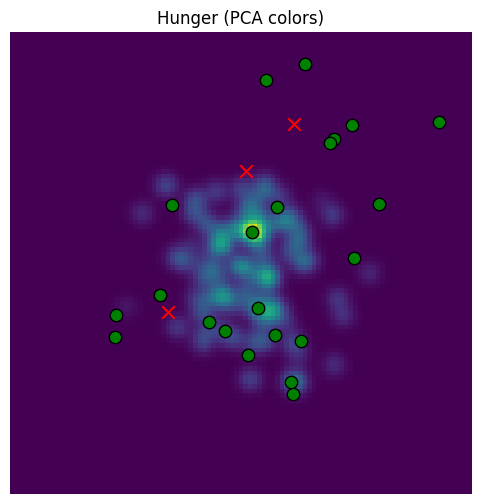

In [23]:
sampled_beliefs_for_hunger = sample_memory(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    search_key=y_hunger[None, ...],
    num_samples=1000,
    temperature=None
).squeeze(0)

def make_overlay(beliefs: torch.Tensor):
    overlay = beliefs.sum(dim=0)
    overlay = overlay / overlay.max()
    overlay = overlay * 0.8 + 0.2
    return overlay

sampled_beliefs_for_hunger_overlay = make_overlay(sampled_beliefs_for_hunger)

_ = plot_sensor_field_overlay(sampled_beliefs_for_hunger_overlay, key="Hunger")

Our default temperature ($T = \sqrt{D}$) is too focused. Let's raise the temperature.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/1874700460.py:20: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


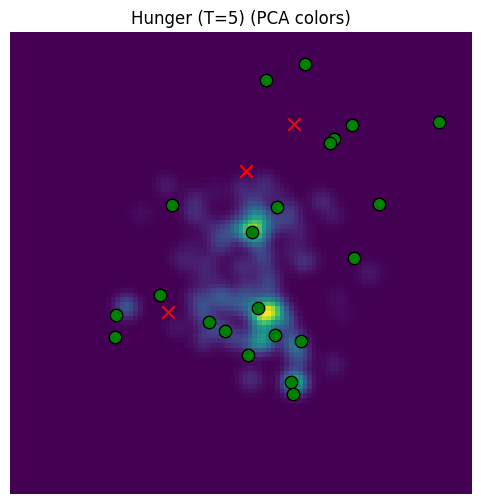

In [24]:
temperature=5
sampled_beliefs_for_hunger_high_temperature = sample_memory(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    search_key=y_hunger[None, ...],
    num_samples=1000,
    temperature=temperature
).squeeze(0)

def make_overlay(beliefs: torch.Tensor):
    overlay = beliefs.sum(dim=0)
    overlay = overlay / overlay.max()
    overlay = overlay * 0.8 + 0.2
    return overlay

sampled_beliefs_for_hunger_high_temperature_overlay = make_overlay(sampled_beliefs_for_hunger_high_temperature)

_ = plot_sensor_field_overlay(sampled_beliefs_for_hunger_high_temperature_overlay, key=f"Hunger (T={temperature})")

Better (recall that our location samples are focused around the origin), but it's very blotchy because we're just sampling the spots out of memory. Let's add a baseline prob, blurring, and slight sharpening.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/1874700460.py:20: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


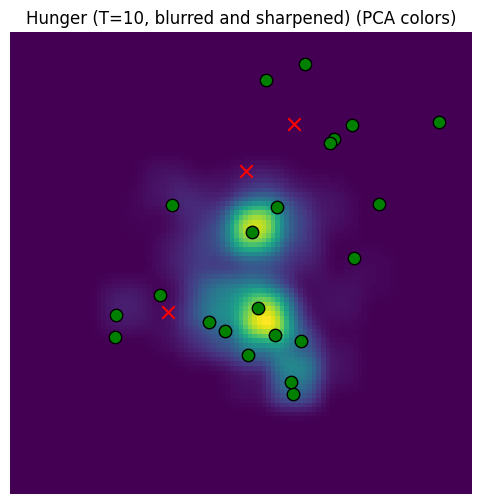

In [25]:
sampled_beliefs_for_hunger_high_temperature = sample_memory(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    search_key=y_hunger[None, ...],
    num_samples=1000,
    temperature=5,
    baseline=1e-5,  # note there are S^2 = 1e4 locations in the grid, so this is < 1 / S^2
    gaussian_blur=5,  # Blur by pixels w.r.t S
    sharpen=1.2
).squeeze(0)

def make_overlay(beliefs: torch.Tensor):
    overlay = beliefs.sum(dim=0)
    overlay = overlay / overlay.max()
    overlay = overlay * 0.8 + 0.2
    return overlay

sampled_beliefs_for_hunger_high_temperature_overlay = make_overlay(sampled_beliefs_for_hunger_high_temperature)

_ = plot_sensor_field_overlay(sampled_beliefs_for_hunger_high_temperature_overlay, key="Hunger (T=10, blurred and sharpened)")

Now we have a better sampler that produces beliefs over the entire space.

The last piece we need is to sample with reference to a particular search distribution. This will require us to compare locations as well as sensory data to generate an affinity score. 

Note that we'll need to protect against the possibility that nothing is close, in which case we should just sample the sensory data.

We'll also want to explicit scale the location affinity to have a maximum value of $1$. In perfect world, softmax would naturally implement this, but the numbers will be better numerically conditioned if we do this scaling, since ill conditioning may occur when the reference is far away from the nearest memory entries.

We'll add the ability to scale the reference location affinity with a power $\beta > 0$ as well, which will control how tightly the reference is enforce. In the end, the formula for selecting entry $t$ with sensory data $x_t$, location $\ell_t$, search key $k$, and reference location $\rho$ is
$$
p(t |  k) \propto \exp\left\{ \frac{1}{T} \left(x_t \cdot k\right) \left(\ell_t \cdot \rho\right)^\beta \right\},
$$
where we treat $\ell_t$ and $\rho$ as flattened vectors to take their dot product.

In [26]:
def sample_memory_with_reference(
    memory_locations: torch.Tensor, memory_values: torch.Tensor, search_key: torch.Tensor, 
    reference_location: Optional[torch.Tensor]=None,
    num_samples: int=1, temperature: Optional[float]=None, 
    baseline: Optional[float]=None, sharpen: Optional[float]=None, gaussian_blur: Optional[float]=None,
    reference_sharpening: Optional[float]=None,
):
    # memory_locations has shape (N, T, S, S)
    # memory_values has shape (N, T, D)
    # search_key has shape (N, D)
    N, T, S, _ = memory_locations.shape

    if temperature is None:
        temperature = memory_values.shape[-1]**(0.5)

    memory_locations = memory_locations.view(N, T, S*S)
    reference_location = reference_location.view(N, S*S, 1)

    # compute the alignment scores (N, T)
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)

    if reference_location is not None:
        location_affinity = torch.bmm(memory_locations, reference_location).squeeze(-1)
        location_max = location_affinity.max(dim=-1, keepdim=True).values
        invalid_mask = location_max < 1e-8
        location_affinity = location_affinity / location_max
        if reference_sharpening is not None:
            location_affinity = location_affinity.pow(reference_sharpening)
            
        s_t = torch.where(invalid_mask, s_t, s_t * location_affinity)

    w_t = torch.softmax(s_t / temperature, dim=-1)

    # sample from the mixture, result will be (N, num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, S*S)    # (N, num_samples, S^2)

    renormalize = False
    loc = memory_locations.gather(dim=-2, index=t)

    if baseline is not None:
        loc = loc + baseline   # make every location possible; value should be significantly less than 1 / S^2
        renormalize = True

    if sharpen is not None:
        loc = loc.pow(sharpen)
        loc = loc / loc.sum(dim=-1, keepdim=True)
        renormalize = True

    if gaussian_blur is not None:
        img = loc.view(N, -1, S, S)
        img = torchvision.transforms.GaussianBlur(kernel_size=int(2*gaussian_blur + 1), sigma=gaussian_blur)(img)
        loc = img.view(N, -1, S*S)
        renormalize = True
    
    if renormalize:
        loc = loc / loc.sum(dim=-1, keepdim=True)

    return loc.view(N, -1, S, S)

A small change, just multiplying in the location affinity before sampling. Now let's sample conditioning on a reference location belief, shown with a purple square below. We'll do this without Gaussian blur so that the pattern is more visible.

In [27]:
print(f"all_location_beliefs.shape: {all_location_beliefs.shape}")
point = torch.tensor([0, 100])
indices = map_space_to_preindex(point, R, gamma).round().long()

print(f"indices: {indices}")
reference_location_belief = all_location_beliefs.view(S, S, S, S)[indices[0], indices[1]]

all_location_beliefs.shape: torch.Size([1, 10201, 10201])
indices: tensor([50, 60])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/1874700460.py:20: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


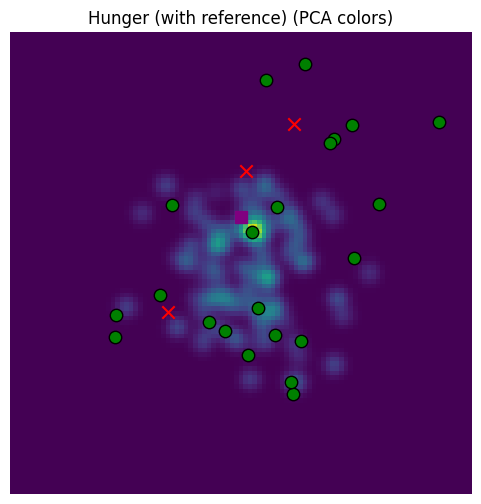

In [28]:
sampled_beliefs_for_hunger_with_reference = sample_memory_with_reference(
    memory_locations=random_memory_locations,
    memory_values=random_memory_values,
    search_key=y_hunger[None, ...],
    reference_location=reference_location_belief,
    reference_sharpening=5,
    num_samples=1000,
    temperature=5,
    baseline=1e-5,
    gaussian_blur=None,
    sharpen=1.2
).squeeze(0)

sampled_beliefs_for_hunger_with_reference_overlay = make_overlay(sampled_beliefs_for_hunger_with_reference)

_, fig, ax= plot_sensor_field_overlay(sampled_beliefs_for_hunger_with_reference_overlay, key="Hunger (with reference)")

ax.scatter(
    point[0],
    point[1],
    c="purple",
    marker="s",
    s=80,
)

## Pruning the Memory

With $N=1$, $T=32,768$, $S=101$, and $D=1024$, this memory can fit about an hour of memories at 10 frames per second with FP16 precision. This is good enough, but a context length of $T=32,768$ will be slow. It would be better to keep the memory smaller.

We can prune the memory using the same approach described in [Developing Spatial Memory](./map_testing.ipynb).

In [29]:
def generate_prune_candidates(
    error_leave_one_out: torch.Tensor, dependencies_leave_one_out: torch.Tensor, max_error_to_prune: float=0.05
):
    # remove candidates that are a dependency of another candidate with a lower error
    sorted_error, error_indices = torch.sort(error_leave_one_out, dim=-1)
    unsort_indices = torch.argsort(error_indices, dim=-1)

    dependencies = dependencies_leave_one_out.gather(
        dim=-2, index=error_indices[..., None].repeat(1, 1, dependencies_leave_one_out.shape[-1])
    ).gather(
        dim=-1, index=error_indices[..., None, :].repeat(1, dependencies_leave_one_out.shape[-1], 1)
    )

    # generate a list of all candidates, ignoring dependencies
    candidates = sorted_error < max_error_to_prune

    # remove candidates with zero dependencies
    num_dependencies = dependencies.long().sum(dim=-1)
    candidates = candidates & (num_dependencies > 0)

    # remove candidates that are a dependency of another candidate with a lower error
    dependencies_mask = torch.tril(dependencies, diagonal=-1).any(dim=-1)
    candidates = candidates & dependencies_mask

    return candidates.gather(dim=-1, index=unsort_indices) 

def prune_one_step(
    memory_locations: torch.Tensor, memory_values: torch.Tensor,
    max_error_to_prune: float=0.05, match_threshold: float=None
):
    N, T, S, _ = memory_locations.shape
    _, _, D = memory_values.shape

    if match_threshold is None:
        match_threshold = 2 / (S*S)

    sense, weights = memory_read(
        memory_locations, 
        memory_values, 
        memory_locations,
        match_threshold=match_threshold, 
        mask_diagonal=True,
        return_weights=True
    )

    memory_locations = memory_locations.view(N, T, S*S)

    error = torch.norm(sense - memory_values, dim=-1)
    dependencies = weights > (1 / T)

    prune_candidates = generate_prune_candidates(error, dependencies, max_error_to_prune)

    # decide what to prune
    mem_size = prune_candidates.shape[-1]
    prune_size = mem_size -prune_candidates.long().sum(dim=-1).max().item()
    scores = mem_size - prune_candidates.float() * torch.arange(prune_candidates.shape[-1], device=prune_candidates.device)[None, ...]

    _, pruned_indices = torch.topk(scores, k=prune_size, dim=-1)

    pruned_indices_loc = pruned_indices[..., None].repeat(1, 1, S*S)
    pruned_indices_sense = pruned_indices[..., None].repeat(1, 1, D)

    pruned_memory_locations = memory_locations.gather(dim=-2, index=pruned_indices_loc).view(N, -1, S, S)
    pruned_memory_values = memory_values.gather(dim=-2, index=pruned_indices_sense)

    num_pruned = prune_candidates.sum(dim=-1)

    return num_pruned, pruned_memory_locations, pruned_memory_values

def prune(memory_locations, memory_values, max_error_to_prune: float=0.05, match_threshold: float=None, max_prune_steps: int=10):
    for _ in range(max_prune_steps):
        num_pruned, memory_locations, memory_values = prune_one_step(memory_locations, memory_values, max_error_to_prune, match_threshold)
        print(f"num_pruned: {num_pruned}")
        if num_pruned.max().item() == 0:
            break
    
    return memory_locations, memory_values

In [30]:
pruned_memory_locations, pruned_memory_values = prune(memory_locations, memory_values)

print(f"pruned_memory_locations.shape: {pruned_memory_locations.shape}")
print(f"pruned_memory_values.shape: {pruned_memory_values.shape}")

print(f"Started with {memory_locations.shape[1]} memory locations")
print(f"Pruned to {pruned_memory_locations.shape[1]} memory locations")

Total invalid: 0
num_pruned: tensor([8672])
Total invalid: 6
num_pruned: tensor([248])
Total invalid: 10
num_pruned: tensor([186])
Total invalid: 10
num_pruned: tensor([147])
Total invalid: 10
num_pruned: tensor([71])
Total invalid: 11
num_pruned: tensor([27])
Total invalid: 11
num_pruned: tensor([14])
Total invalid: 11
num_pruned: tensor([5])
Total invalid: 11
num_pruned: tensor([5])
Total invalid: 11
num_pruned: tensor([0])
pruned_memory_locations.shape: torch.Size([1, 826, 101, 101])
pruned_memory_values.shape: torch.Size([1, 826, 1024])
Started with 10201 memory locations
Pruned to 826 memory locations


Total invalid: 2179
pruned_memory_read.shape: torch.Size([1, 10201, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


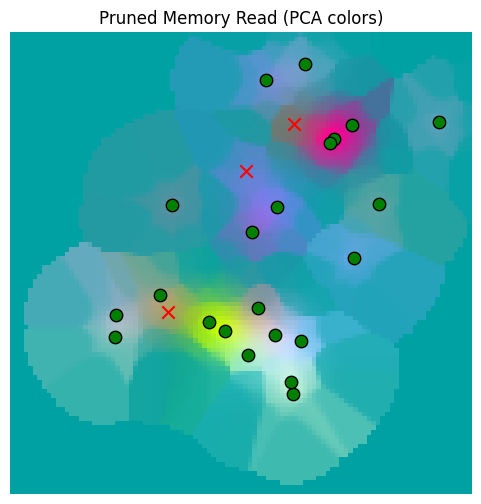

In [31]:
pruned_memory_read_result = memory_read(
    memory_locations=pruned_memory_locations,
    memory_values=pruned_memory_values,
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
)

print(f"pruned_memory_read.shape: {pruned_memory_read_result.shape}")

_ = plot_sensor_field(pruned_memory_read_result.squeeze(0), "Pruned Memory Read")

So from our overall sensor grid, we pruned from 10,201 entries down to 912 locations with reasonable fidelity retained.

## Implementation of `LocationBeliefMemory`

The functions above are implemented in `tree_world.models.memory_belief.LocationBeliefMemory`.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


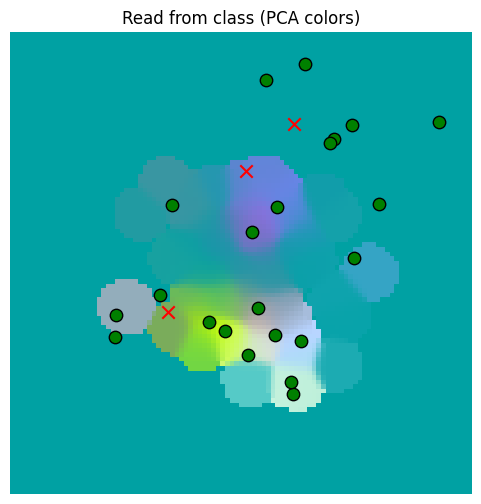

In [32]:
from tree_world.models.memory_belief import LocationBeliefMemory

memory = LocationBeliefMemory(location_dim=2, sensory_dim=1024, embed_dim=1024)

memory.write(random_location_beliefs.view(1, -1, S, S), random_sensor_values.view(1, -1, 1024))

read_from_class = memory.read(
    all_location_beliefs.view(1, -1, S, S),
)

_ = plot_sensor_field(read_from_class.squeeze(0), "Read from class")

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/1874700460.py:20: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


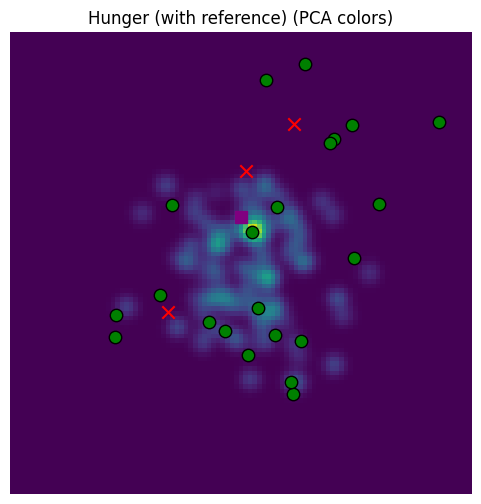

In [33]:
sampled_beliefs_for_hunger_class = memory.sample(
    search_key=y_hunger[None, ...],
    reference_location=reference_location_belief,
    reference_sharpening=5,
    num_samples=1000,
    temperature=5,
    baseline=1e-5,
    gaussian_blur=None,
    sharpen=1.2
).squeeze(0)

sampled_beliefs_for_hunger_with_reference_overlay = make_overlay(sampled_beliefs_for_hunger_with_reference)

_, fig, ax= plot_sensor_field_overlay(sampled_beliefs_for_hunger_with_reference_overlay, key="Hunger (with reference)")

ax.scatter(
    point[0],
    point[1],
    c="purple",
    marker="s",
    s=80,
)

Pruned 9375 memory locations
pruned_memory_read_class.shape: torch.Size([1, 10201, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_51075/604238629.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


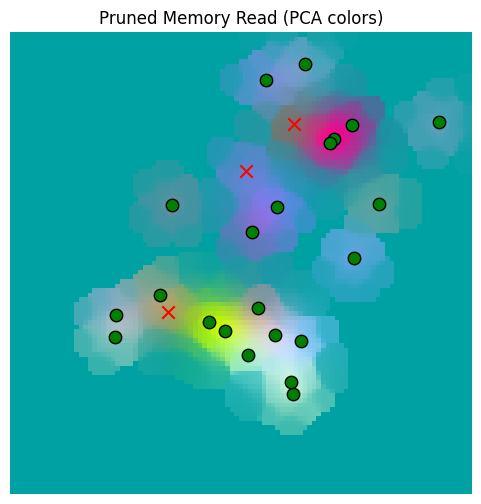

In [34]:
memory = LocationBeliefMemory(location_dim=2, sensory_dim=1024, embed_dim=1024)

memory.write(memory_locations.view(1, -1, S, S), memory_values.view(1, -1, 1024))

num_removed = memory.prune(max_error_to_prune=0.05, match_threshold=None, max_prune_steps=10)

print(f"Pruned {num_removed} memory locations")

pruned_memory_read_result_class = memory.read(
    location_beliefs=all_location_beliefs.view(1, -1, S, S),
)

print(f"pruned_memory_read_class.shape: {pruned_memory_read_result_class.shape}")

_ = plot_sensor_field(pruned_memory_read_result_class.squeeze(0), "Pruned Memory Read")

# Conclusion

We've built a memory off of location belief pixel maps and demonstrated writing, reading, sampling and pruning. Now we can use these as part of a location aware agent.